# 0. Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Loading Dataset

In [2]:
import numpy as np
import scipy.io
mat = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/Data/data_mmwave_900.mat')

In [3]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'label_test', 'label_train', 'mmwave_data_test', 'mmwave_data_train', 'p'])

In [ ]:
print("min:{}, max:{}, median:{}, mean:{}, std:{}".format(mat['mmwave_data_train'].min(),
                                       mat['mmwave_data_train'].max(),
                                       np.median(mat['mmwave_data_train']),
                                       mat['mmwave_data_train'].mean(),
                                       mat['mmwave_data_train'].std()
                                      ))

min:0.0, max:115334.25797202799, median:0.0, mean:117.18857548446485, std:813.6971811864285


In [ ]:
mat['mmwave_data_train'].shape

(900, 256, 63)

# 2. Prepare Data

In [ ]:
train_data = mat['mmwave_data_train'].reshape([900,256,63,1])
test_data  = mat['mmwave_data_test'].reshape([900,256,63,1])

train_labels = np.zeros([900,6])
for i, l in enumerate(mat['label_train']):
    train_labels[i,l[0]]=1
    
test_labels  = np.zeros([900,6])
for i, l in enumerate(mat['label_test']):
    test_labels[i,l[0]]=1

# 3. CNN

## 3.1. Define CNN model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(256, 63,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(6))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 63, 16)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 63, 16)       64        
_________________________________________________________________
activation (Activation)      (None, 256, 63, 16)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 32, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 32, 16)       2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 16)       64        
_________________________________________________________________
activation_1 (Activation)    (None, 128, 32, 16)       0

## 3.2. Train CNN

In [ ]:
history_CNN = model.fit(train_data, train_labels,
                        epochs=10,
                        batch_size=16,
                        validation_split=.2
                        #validation_data=(test_data, test_labels)
                        )

Epoch 1/10
45/45 [==============================] - 13s 256ms/step - loss: 1.2189 - accuracy: 0.5539 - val_loss: 0.5939 - val_accuracy: 0.8278
Epoch 2/10
45/45 [==============================] - 11s 242ms/step - loss: 0.4721 - accuracy: 0.8830 - val_loss: 0.3952 - val_accuracy: 0.9778
Epoch 3/10
45/45 [==============================] - 11s 240ms/step - loss: 0.2610 - accuracy: 0.9390 - val_loss: 0.2658 - val_accuracy: 0.9944
Epoch 4/10
45/45 [==============================] - 11s 240ms/step - loss: 0.1432 - accuracy: 0.9878 - val_loss: 0.3236 - val_accuracy: 0.9222
Epoch 5/10
45/45 [==============================] - 11s 241ms/step - loss: 0.0933 - accuracy: 0.9975 - val_loss: 0.1068 - val_accuracy: 0.9889
Epoch 6/10
45/45 [==============================] - 11s 241ms/step - loss: 0.0669 - accuracy: 0.9982 - val_loss: 0.1180 - val_accuracy: 0.9833
Epoch 7/10
45/45 [==============================] - 11s 241ms/step - loss: 0.0534 - accuracy: 0.9904 - val_loss: 0.0441 - val_accuracy: 0.9944

## 3.3. Evaluate model

In [ ]:
eval_test_CNN = model.evaluate(test_data, test_labels,verbose=1)
print("test accuracy:", eval_test_CNN[1])

29/29 [==============================] - 3s 117ms/step - loss: 0.0069 - accuracy: 1.0000
test accuracy: 1.0


29/29 [==============================] - 4s 117ms/step
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


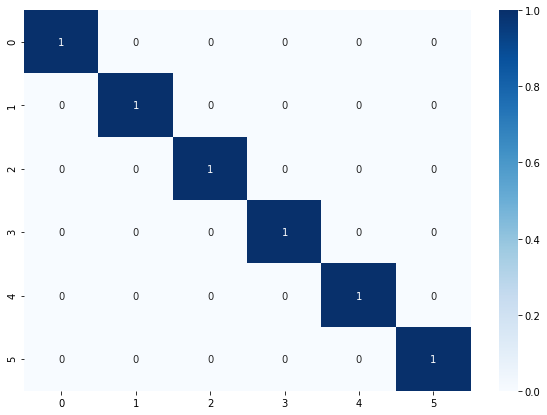

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred=model.predict(test_data,verbose=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(test_labels,axis=1), np.argmax(y_pred,axis=1), normalize='true')

df_cm = pd.DataFrame(cm, index = ["0","1","2","3","4","5"],
                  columns = ["0","1","2","3","4","5"])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
print(cm)

# 4. MLP

## 4.1. Define MLP model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()

model.add(Flatten(input_shape=(256, 63,1)))  # this converts our 3D images to 1D feature vectors
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(6))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16128)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2064512   
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
activation_8 (Activation)    (None, 128)              

## 4.2. Train MLP 

In [ ]:
history_MLP = model.fit(train_data, train_labels,
                        epochs=10,
                        batch_size=16,
                        validation_split=.2
                        #validation_data=(test_data, test_labels)
                        )

Epoch 1/10
45/45 [==============================] - 2s 19ms/step - loss: 0.8191 - accuracy: 0.7584 - val_loss: 0.1574 - val_accuracy: 1.0000
Epoch 2/10
45/45 [==============================] - 1s 12ms/step - loss: 0.0839 - accuracy: 0.9933 - val_loss: 0.0734 - val_accuracy: 1.0000
Epoch 3/10
45/45 [==============================] - 1s 12ms/step - loss: 0.0494 - accuracy: 0.9988 - val_loss: 0.0372 - val_accuracy: 1.0000
Epoch 4/10
45/45 [==============================] - 1s 12ms/step - loss: 0.0223 - accuracy: 1.0000 - val_loss: 0.0184 - val_accuracy: 1.0000
Epoch 5/10
45/45 [==============================] - 1s 12ms/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 6/10
45/45 [==============================] - 1s 13ms/step - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 7/10
45/45 [==============================] - 1s 12ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 8/10
45

## 4.3. Evaluate model

In [ ]:
eval_test_MLP = model.evaluate(test_data, test_labels,verbose=1)
print("test accuracy:", eval_test_MLP[1])

29/29 [==============================] - 0s 5ms/step - loss: 0.0023 - accuracy: 1.0000
test accuracy: 1.0


29/29 [==============================] - 0s 4ms/step
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


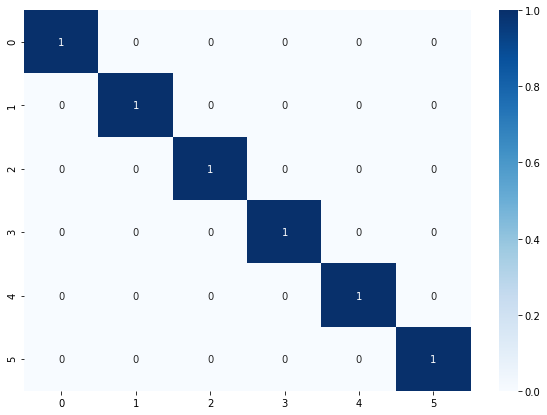

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred=model.predict(test_data,verbose=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(test_labels,axis=1), np.argmax(y_pred,axis=1), normalize='true')

df_cm = pd.DataFrame(cm, index = ["0","1","2","3","4","5"],
                  columns = ["0","1","2","3","4","5"])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
print(cm)

#5. SVM

## 5.1. Train SVM 

In [ ]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(train_data.reshape(900,-1), np.argmax(train_labels, axis=1).tolist())

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

##5.2. Evaluate model

In [ ]:
np.mean(clf.predict(test_data.reshape(900,-1))==np.argmax(test_labels, axis=1).tolist())

0.9988888888888889

[[1.         0.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.00666667 0.         0.99333333]]


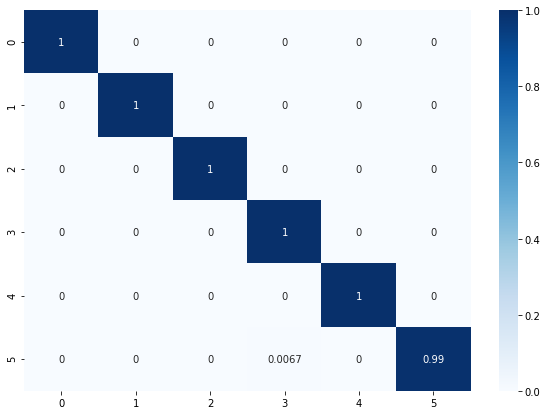

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred=clf.predict(test_data.reshape(900,-1))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(test_labels,axis=1), y_pred, normalize='true')

df_cm = pd.DataFrame(cm, index = ["0","1","2","3","4","5"],
                  columns = ["0","1","2","3","4","5"])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
print(cm)

#6. ADABOOST

## 6.1. Train ADABOOST 

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(train_data.reshape(900,-1), np.argmax(train_labels, axis=1).tolist())


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

##6.2. Evaluate model

In [ ]:
np.mean(clf.predict(test_data.reshape(900,-1))==np.argmax(test_labels, axis=1).tolist())

0.4922222222222222

[[1.         0.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.03333333 0.         0.95333333 0.00666667 0.00666667 0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.99333333 0.00666667 0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]]


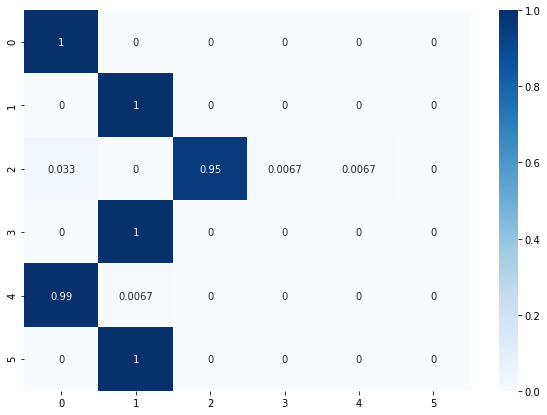

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred=clf.predict(test_data.reshape(900,-1))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(test_labels,axis=1), y_pred, normalize='true')

df_cm = pd.DataFrame(cm, index = ["0","1","2","3","4","5"],
                  columns = ["0","1","2","3","4","5"])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
print(cm)

#7. Comparison

##7.1 Train Loss

Text(0.5, 1.0, 'Training Loss')

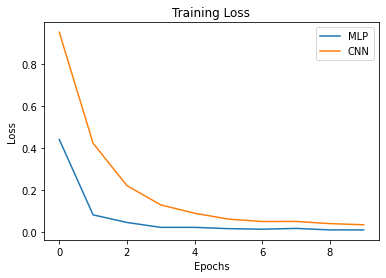

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_MLP.history['loss'])
plt.plot(history_CNN.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['MLP','CNN'])
plt.title('Training Loss')

##7.2. Train Accuracy

Text(0.5, 1.0, 'Training Accuracy')

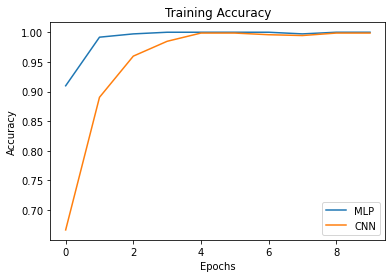

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_MLP.history['accuracy'])
plt.plot(history_CNN.history['accuracy'])
#plt.plot(history_SVM.history['accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['MLP','CNN'])
plt.title('Training Accuracy')

##7.3. Validation Loss

Text(0.5, 1.0, 'Validation Loss')

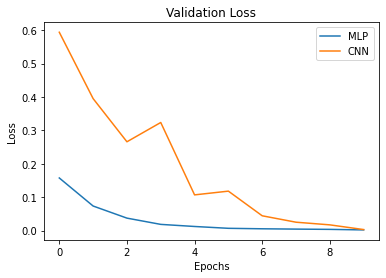

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_MLP.history['val_loss'])
plt.plot(history_CNN.history['val_loss'])
#plt.plot(history_SVM.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['MLP','CNN'])
plt.title('Validation Loss')

##7.4. Validation Accuracy

Text(0.5, 1.0, 'Validation Accuracy')

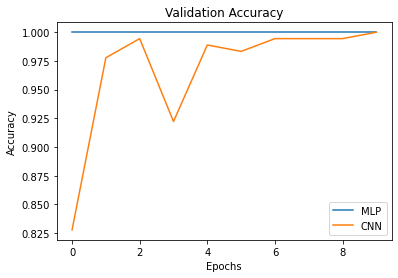

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_MLP.history['val_accuracy'])
plt.plot(history_CNN.history['val_accuracy'])
#plt.plot(history_SVM.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['MLP','CNN'])
plt.title('Validation Accuracy')